# Analyse des données liées au COVID-19 en France
Données issues de l'Agance nationale de santé publique (Santé publique France).

## Importation des modules

In [1]:
import requests

In [2]:
from datetime import datetime
now = datetime.now()

In [3]:
import pandas as pd 

In [4]:
import numpy as np 

In [5]:
import matplotlib.pyplot as plt 
%matplotlib inline

## Fonctions

In [6]:
# Récupération des fichiers .csv
# url = URL du fichier .csv à télécharger (str)
# file_name = nommer le fichier téléchargé (str)

def get_csv(url, file_name):
    req = requests.get(url) # Envoi de la requête

    if req.status_code == 200:
        print("LINK OK")
    else:
        print(req.status_code)

    url_content = req.content # Binary content
    csv_file = open(f'{file_name}.csv', 'wb')

    csv_file.write(url_content)
    csv_file.close()

    when = now.strftime("%d/%m/%Y à %H:%M:%S")
    print("Dernière mise à jour du CSV le", when)

    return pd.read_csv(f'{file_name}.csv', sep=";")

In [7]:
# Fonction calculant les variations de valeurs dans une série sous la forme d'un plot.bar à deux barres
# series = Prend un pandas.Series en paramètres
# mode="day" : Variation entre aujourd'hui et hier
# mode="week" : Variation entre les 7 derniers jours et les 7 précédents
# title="" : Titre du graph
# grid = False/True : Afficher ou non la grille
# absolute=True : Affiche la valeur absolue sur le graph
# absolute=False : Affiche la valeur avec l'opérateur +/- en préfixe sur le graph
# inv_color=False : La barre représantant la valeur la plus récente apparait en rouge si elle est supérieure
# inv_color=True : La barre représantant la valeur la plus récente apparait en vert si elle est supérieure  

def vario(series, mode="day", title="", grid=False, absolute=False, inv_color = False):
    if mode == "day":
        last = series[len(series)-1]
        b_last = series[len(series)-2]
        diff = last - b_last
        perc = round(((last/b_last)*100)-100, 2)

    if mode == "week":
        last_week = []
        b_last_week = []
        i = len(series)-1

        while i > (len(series)-1) - 7:
            last_week.append(series[i])
            i-=1

        while i > (len(series)-1) - 14:
            b_last_week.append(series[i])
            i-=1
        
        last = sum(last_week)
        b_last = sum(b_last_week)
        diff = last - b_last
        perc = round(((last/b_last)*100)-100, 2)

    color = ["lime", "coral"]
    if inv_color:
        color.reverse()

    if last > b_last: # Variation +
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = color

    elif last == b_last: # No variation
        if mode == "day":
            print(f"Variation journalière = +{diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = +{diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color = ["b", "b"]

    else : # Variation -
        if mode == "day":
            print(f"Variation journalière = {diff} [{perc}%] (Auj. : {last}, hier : {b_last})")
        else :
            print(f"Variation hébdomadaire = {diff} [{perc}%] (Cette sem. : {last}, Sem. der. : {b_last})")
        color.reverse()
    
    when = now.strftime("Le %d/%m/%Y")

    if mode == "day":
        df = pd.DataFrame({'jour':['Hier.', 'Auj.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='jour', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")
    else:
        df = pd.DataFrame({'semaine':['Sem. der.', 'Cette sem.'], 'y':[b_last, last]})
        ax = df.plot.bar(x='semaine', y='y', rot=0, color=color, legend=False, title = f"{title}\n ({when})")

    x_offset = -0.1

    for p in ax.patches:
        b = p.get_bbox()
        if absolute:
            val = "{:.0f}".format(b.y1)
        else :
            val = "{:+.0f}".format(b.y1)     
        ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 - (b.y1/10)))
    
    return ax

In [8]:
# Tableau détaillé pour les classes d'âge
def tab(series, colname="values"):
    # series = cova_day.groupby("cl_age90").dc.sum()
    # series = cova.dc
    total = series[0]
    series = series.drop(0)
    nc = total - sum(series)
    nc_p = round((nc/total)*100, 1)

    perc = []
    i = 0
    for val in series:
        res = (val/total)*100
        res = round(res, 1)
        perc.append(res)
        i+=1
    perc.append(nc_p)
    perc.append(100)

    labels = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89", "90+", "NC", "Total"]
    values = list(series)
    values.append(nc)
    values.append(total)

    data = {"Classe d'âge": labels, colname:values, "Pourcentage":perc}

    df = pd.DataFrame(data, columns=["Classe d'âge", colname, "Pourcentage"])

    return df

## Récupération des fichiers .csv

### Données hospitalières cumulées
Données cumulées depuis le début des mesures en mars 2020.

In [9]:
url = "https://www.data.gouv.fr/fr/datasets/r/63352e38-d353-4b54-bfd1-f1b3ee1cabd7"
cov = get_csv(url, ".\csv\cov")

LINK OK
Dernière mise à jour du CSV le 02/12/2020 à 21:27:23


### Nouvelles données hospitalières
Variations journalières des données hospitalières

In [10]:
url = "https://www.data.gouv.fr/fr/datasets/r/6fadff46-9efd-4c53-942a-54aca783c30c"
covn = get_csv(url, ".\csv\covn")

LINK OK
Dernière mise à jour du CSV le 02/12/2020 à 21:27:23


### Données par classes d'âge
Données hospitalières en fonction de la classe d'âge des patients

In [11]:
url = "https://www.data.gouv.fr/fr/datasets/r/08c18e08-6780-452d-9b8c-ae244ad529b3"
cova = get_csv(url, ".\csv\cova")

LINK OK
Dernière mise à jour du CSV le 02/12/2020 à 21:27:23


### Données de dépistage
Nombre de personnes testées et nombre de personnes déclarées positives par sexe et classe d'âge et par département

In [12]:
url = "https://www.data.gouv.fr/fr/datasets/r/406c6a23-e283-4300-9484-54e78c8ae675"
covd = get_csv(url, ".\csv\covd")

LINK OK
Dernière mise à jour du CSV le 02/12/2020 à 21:27:23


## Visualisations

### Par type de cas hospitalier
### Zone : tout le territoire

In [13]:
# Pour chaque nouvelle entrée et pour chaque département, le fichier cov.csv présente 3 lignes liées au sexe du patient
# 1 pour homme, 2 pour femme et 0 pour la somme des hommes et des femmes
# Nous filtrons ici le dataframe pour en créer 3 autres selon la valeur du sexe
cov_0 = cov.loc[cov['sexe'] == 0] # Hommes et femmes
cov_1 = cov.loc[cov['sexe'] == 1] # Uniquement hommes
cov_2 = cov.loc[cov['sexe'] == 2] # Uniquement femmes

### Réanimations

In [14]:
cov_rea = cov_0.groupby("jour").rea.sum()

Variation journalière = -116 [-3.23%] (Auj. : 3478, hier : 3594)


<AxesSubplot:title={'center':'Nombres de personnes en réanimation\n ou en soins intensifs (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

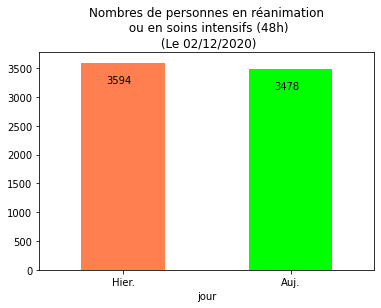

In [15]:
# Variations jour
vario(cov_rea, title="Nombres de personnes en réanimation\n ou en soins intensifs (48h)", absolute=True)

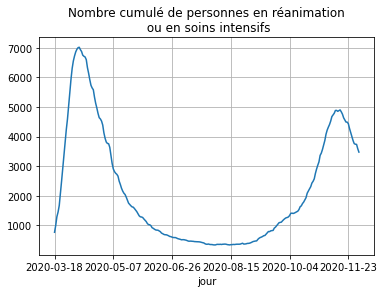

In [16]:
# Réanimations total
rea_graph = cov_rea.plot(grid=True, title="Nombre cumulé de personnes en réanimation\n ou en soins intensifs")

<AxesSubplot:title={'center':'Nombre quotidien de nouvelles admissions en réanimation'}, xlabel='jour'>

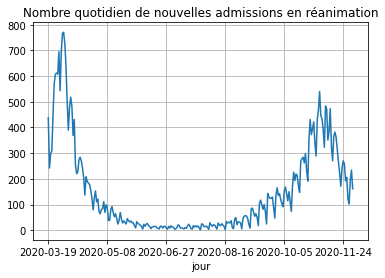

In [17]:
# Nouvelles réanimations
covn_rea = covn.groupby("jour").incid_rea.sum()
covn_rea.plot(title="Nombre quotidien de nouvelles admissions en réanimation", grid=True)

Variation journalière = -73 [-31.2%] (Auj. : 161, hier : 234)


<AxesSubplot:title={'center':'Nouvelles admissions en réanimation (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

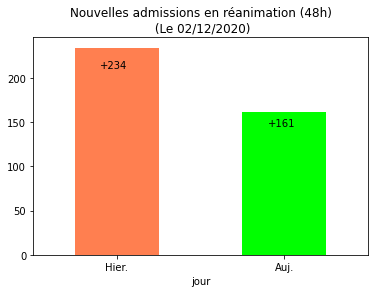

In [18]:
# Variation nouvelles admissions en réanimation
vario(covn_rea, title="Nouvelles admissions en réanimation (48h)")

Variation hébdomadaire = -525 [-30.21%] (Cette sem. : 1213, Sem. der. : 1738)


<AxesSubplot:title={'center':'Nouvelles admissions en réanimation (14jr)\n (Le 02/12/2020)'}, xlabel='semaine'>

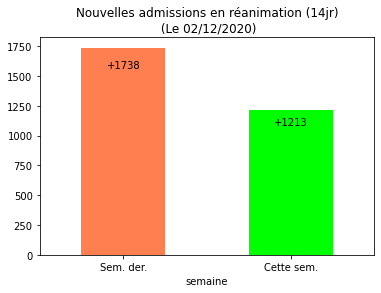

In [19]:
vario(covn_rea, title="Nouvelles admissions en réanimation (14jr)", mode="week")

### Hospitalisations

<AxesSubplot:title={'center':'Nombre cumulé de personnes hospitalisées'}, xlabel='jour'>

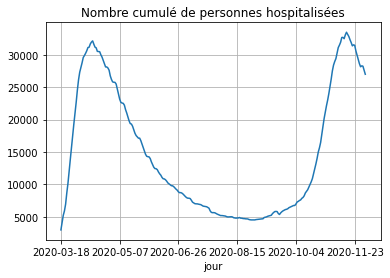

In [20]:
# Hospitalisations
cov_hosp = cov_0.groupby("jour").hosp.sum()
cov_hosp.plot(grid=True, title="Nombre cumulé de personnes hospitalisées")

<AxesSubplot:title={'center':'Nouvelles hospitalisations'}, xlabel='jour'>

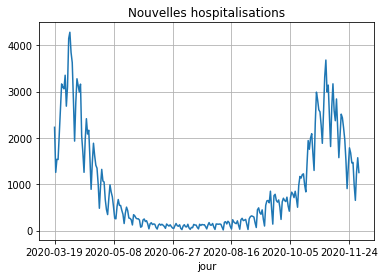

In [21]:
covn_hosp = covn.groupby("jour").incid_hosp.sum()
covn_hosp.plot(title="Nouvelles hospitalisations", grid=True)

Variation journalière = -319 [-20.29%] (Auj. : 1253, hier : 1572)


<AxesSubplot:title={'center':'Nouvelles hospitalisations (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

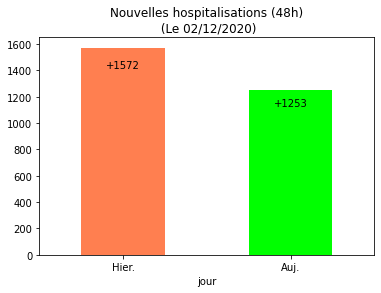

In [22]:
vario(covn_hosp, title="Nouvelles hospitalisations (48h)")

Variation hébdomadaire = -2812 [-24.55%] (Cette sem. : 8641, Sem. der. : 11453)


<AxesSubplot:title={'center':'Nouvelles hospitalisations (14jr)\n (Le 02/12/2020)'}, xlabel='semaine'>

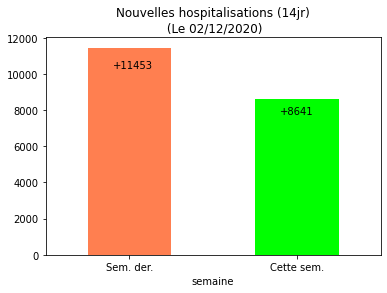

In [23]:
vario(covn_hosp, title="Nouvelles hospitalisations (14jr)", mode="week")

### Décès
Nombre de décès mis à jour quotidiennement pour les décès survenant à l’hôpital, les décès survenant au sein des établissements sociaux et médico-sociaux ne sont ici pas comptabilisés

<AxesSubplot:title={'center':'Nombre de décès cumulé en milieu hospitalier'}, xlabel='jour'>

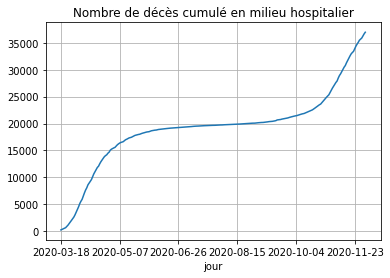

In [24]:
cov_dc = cov_0.groupby("jour").dc.sum()
cov_dc.plot(grid=True, title="Nombre de décès cumulé en milieu hospitalier")

<AxesSubplot:title={'center':'Nouveaux décès'}, xlabel='jour'>

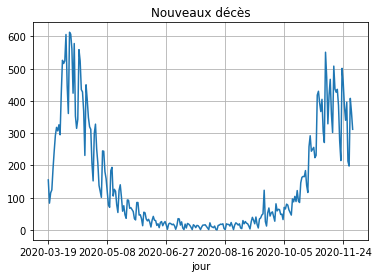

In [25]:
covn_dc = covn.groupby("jour").incid_dc.sum()
covn_dc.plot(title="Nouveaux décès", grid=True)

Variation journalière = -53 [-14.52%] (Auj. : 312, hier : 365)


<AxesSubplot:title={'center':'Nouveaux décès (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

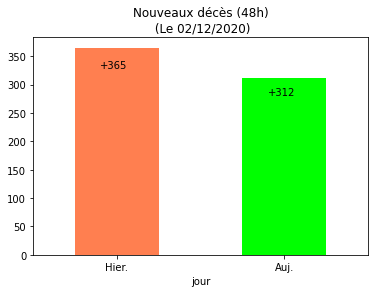

In [26]:
vario(covn_dc, title="Nouveaux décès (48h)")

Variation hébdomadaire = -423 [-15.93%] (Cette sem. : 2232, Sem. der. : 2655)


<AxesSubplot:title={'center':'Nouveaux décès (14jr)\n (Le 02/12/2020)'}, xlabel='semaine'>

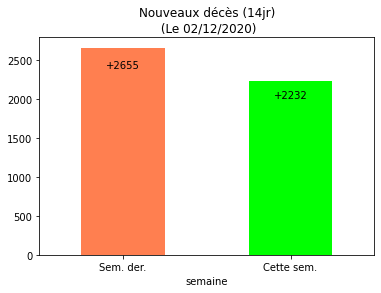

In [27]:
vario(covn_dc, mode="week", title="Nouveaux décès (14jr)")

### Retours à domicile

<AxesSubplot:title={'center':'Nouveaux retours à domicile'}, xlabel='jour'>

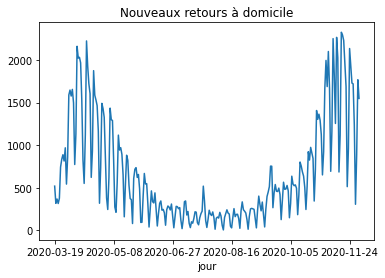

In [28]:
covn_rad = covn.groupby("jour").incid_rad.sum()
covn_rad.plot(title="Nouveaux retours à domicile")

Variation journalière = -219 [-12.39%] (Auj. : 1549, hier : 1768)


<AxesSubplot:title={'center':'Retours à domicile (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

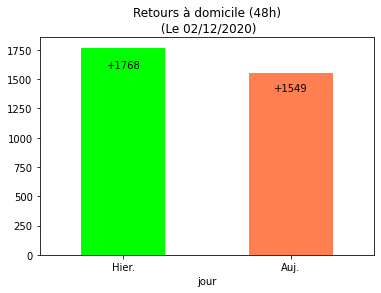

In [29]:
vario(covn_rad, title="Retours à domicile (48h)", inv_color=True)

Variation hébdomadaire = -2227 [-19.49%] (Cette sem. : 9197, Sem. der. : 11424)


<AxesSubplot:title={'center':'Retours à domicile (14jr)\n (Le 02/12/2020)'}, xlabel='semaine'>

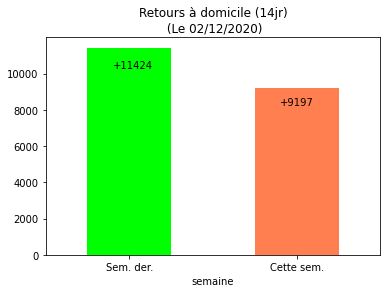

In [30]:
vario(covn_rad, title="Retours à domicile (14jr)", mode="week", inv_color=True)

### Par type de cas hospitalier
### Zone : par département

### Réanimations

In [31]:
dep = "69" # Choix du département

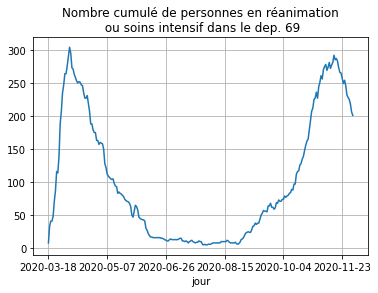

In [32]:
cov_dep = cov_0.loc[cov['dep'] == dep]
title = f"Nombre cumulé de personnes en réanimation\n ou soins intensif dans le dep. {dep}"
rea_1 = cov_dep.plot(x="jour", y="rea", title=title, grid=True, legend=False)

<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69'}, xlabel='jour'>

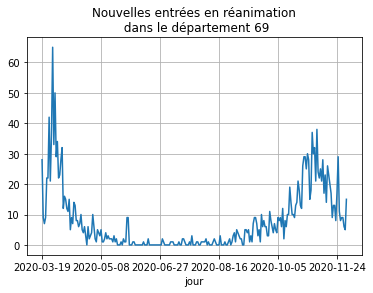

In [33]:
covnDep = covn.loc[covn['dep'] == dep]
covnDep_rea = covnDep.groupby("jour").incid_rea.sum()
covnDep_rea.plot(title=f"Nouvelles entrées en réanimation\n dans le département {dep}", grid=True)

Variation journalière = +10 [200.0%] (Auj. : 15, hier : 5)


<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69 (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

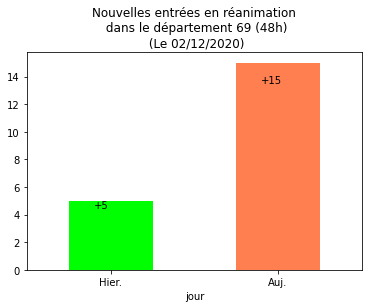

In [34]:
vario(covnDep_rea, title=f"Nouvelles entrées en réanimation\n dans le département {dep} (48h)")

Variation hébdomadaire = -43 [-40.57%] (Cette sem. : 63, Sem. der. : 106)


<AxesSubplot:title={'center':'Nouvelles entrées en réanimation\n dans le département 69 (14jr)\n (Le 02/12/2020)'}, xlabel='semaine'>

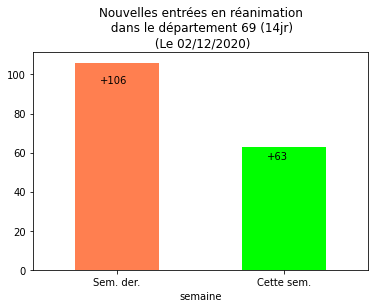

In [35]:
vario(covnDep_rea, title=f"Nouvelles entrées en réanimation\n dans le département {dep} (14jr)", mode="week")

### Décès
Nombre de décès mis à jour quotidiennement pour les décès survenant à l’hôpital, les décès survenant au sein des établissements sociaux et médico-sociaux ne sont ici pas comptabilisés

<AxesSubplot:title={'center':'Nouveaux décès dans le département 69'}, xlabel='jour'>

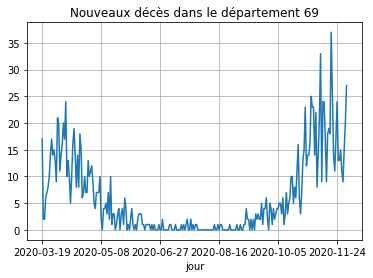

In [36]:
covnDep = covn.loc[covn['dep'] == dep]
covnDep_dc = covnDep.groupby("jour").incid_dc.sum()
covnDep_dc.plot(title=f"Nouveaux décès dans le département {dep}", grid=True)

Variation journalière = +7 [35.0%] (Auj. : 27, hier : 20)


<AxesSubplot:title={'center':'Nouveaux décès dans le département 69 (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

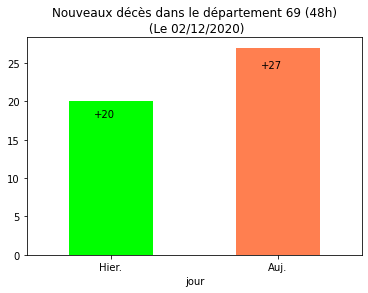

In [37]:
covnDep = covn.loc[covn['dep'] == dep]
covnDep_dc = covnDep.groupby("jour").incid_dc.sum()
vario(covnDep_dc, title=f"Nouveaux décès dans le département {dep} (48h)")

Variation hébdomadaire = -32 [-22.54%] (Cette sem. : 110, Sem. der. : 142)


<AxesSubplot:title={'center':'Nouveaux décès dans le département 69 (14jr)\n (Le 02/12/2020)'}, xlabel='semaine'>

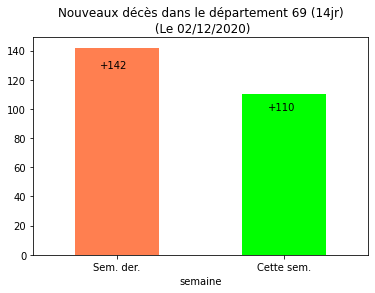

In [38]:
covnDep = covn.loc[covn['dep'] == dep]
covnDep_dc = covnDep.groupby("jour").incid_dc.sum()
vario(covnDep_dc, title=f"Nouveaux décès dans le département {dep} (14jr)", mode="week")

### Hospitalisations

<AxesSubplot:title={'center':'Hospitalisations cumulées dans le département 69'}, xlabel='jour'>

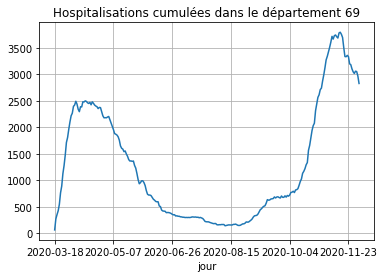

In [39]:
covDep = cov.loc[cov['dep'] == dep]
covDep_hosp = covDep.groupby("jour").hosp.sum()
covDep_hosp.plot(title=f"Hospitalisations cumulées dans le département {dep}", grid=True)

Variation journalière = -4 [-5.19%] (Auj. : 73, hier : 77)


<AxesSubplot:title={'center':'Nouvelles hospitalisations dans le département 69 (48h)\n (Le 02/12/2020)'}, xlabel='jour'>

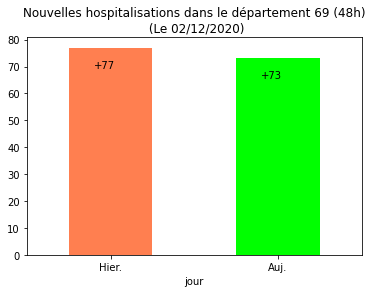

In [40]:
covnDep = covn.loc[covn['dep'] == dep]
covnDep_hosp = covnDep.groupby("jour").incid_hosp.sum()
vario(covnDep_hosp, title=f"Nouvelles hospitalisations dans le département {dep} (48h)")

Variation hébdomadaire = -79 [-14.74%] (Cette sem. : 457, Sem. der. : 536)


<AxesSubplot:title={'center':'Nouvelles hospitalisations dans le département 69 (14jr)\n (Le 02/12/2020)'}, xlabel='semaine'>

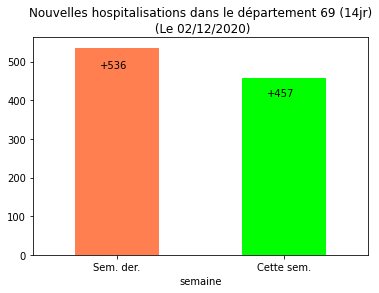

In [41]:
covnDep = covn.loc[covn['dep'] == dep]
covnDep_hosp = covnDep.groupby("jour").incid_hosp.sum()
vario(covnDep_hosp, title=f"Nouvelles hospitalisations dans le département {dep} (14jr)", mode="week")

### Par classes d'âge
### Zone : tout le territoire

### Réanimations

In [42]:
last_dt = cova['jour'].iloc[-1] # Récupération de la dernière date enregistrée du fichier .csv
cova_day = cova.loc[cova["jour"] == last_dt]
cova_rea = cova_day.groupby("cl_age90").rea.sum()
print("Personnes actuellement en réanimation par tranche d'âge")
tab(cova_rea, colname="Réanimations")

Personnes actuellement en réanimation par tranche d'âge


,Classe d'âge,Réanimations,Pourcentage
0,0-9,7,0.2
1,10-19,17,0.5
2,20-29,17,0.5
3,30-39,64,1.8
4,40-49,161,4.6
5,50-59,447,12.9
6,60-69,1087,31.3
7,70-79,1298,37.3
8,80-89,321,9.2
9,90+,31,0.9


<AxesSubplot:title={'center':"Personnes actuellement en réanimation par tranche d'âge\n(Le 02/12/2020)"}, ylabel='rea'>

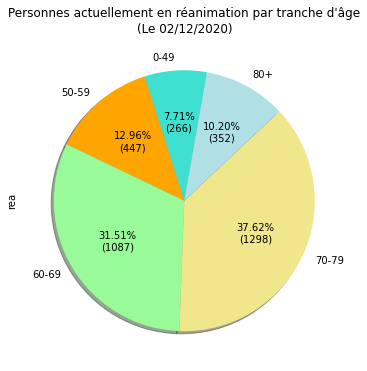

In [43]:
# Graphique
cova_rea = cova_day.groupby("cl_age90").rea.sum()
total_rea = cova_rea[0]
cova_rea = cova_rea.drop(0)
merge_1 = cova_rea[9] + cova_rea[19] + cova_rea[29] + cova_rea[39] + cova_rea[49]
# merge_1 += total_rea - sum(cova_rea) # Comptabiliser les non classés
merge_2 = cova_rea[89] + cova_rea[90]

cova_merge = cova_rea.copy()
cova_merge.loc[49] = merge_1 # Replace
cova_merge.loc[89] = merge_2 # Replace
cova_merge.drop(labels=[9,19,29,39,90], inplace=True)

labels = ["0-49","50-59","60-69","70-79","80+"]

perc = []
i = 0
for val in cova_merge:
    res = (val/total_rea)*100
    res = round(res, 1)
    perc.append(res)
    i+=1

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

colors = ["turquoise", "orange", "palegreen", "khaki", "powderblue"]
when = now.strftime("Le %d/%m/%Y")

cova_merge.plot.pie(title=f"Personnes actuellement en réanimation par tranche d'âge\n({when})", figsize=(6,6), shadow=True, startangle=80, labels=labels, colors=colors, autopct=make_autopct(cova_merge))

### Décès en milieu hospitalier
Nombre de décès mis à jour quotidiennement pour les décès survenant à l’hôpital, les décès survenant au sein des établissements sociaux et médico-sociaux ne sont ici pas comptabilisés

In [44]:
# Tableau détaillé
cova_dc = cova_day.groupby("cl_age90").dc.sum()
print("Nombre cumulé de décès en milieu hospitalier")
tab(cova_dc, colname="Décès cumulés")

Nombre cumulé de décès en milieu hospitalier


,Classe d'âge,Décès cumulés,Pourcentage
0,0-9,4,0.0
1,10-19,5,0.0
2,20-29,33,0.1
3,30-39,139,0.4
4,40-49,399,1.1
5,50-59,1381,3.7
6,60-69,4052,11.0
7,70-79,8168,22.1
8,80-89,14543,39.3
9,90+,8056,21.8


<AxesSubplot:title={'center':'Décès cumulés en milieu hospitalier\n(Le 02/12/2020)'}, ylabel='dc'>

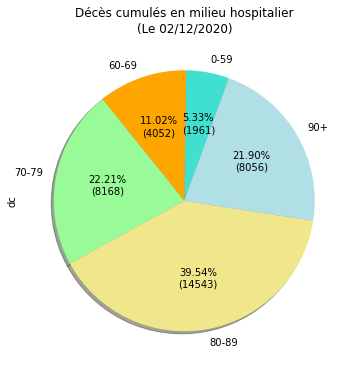

In [45]:
# Graphique
cova_dc = cova_day.groupby("cl_age90").dc.sum()
total_dc = cova_dc[0]
cova_dc = cova_dc.drop(0)
merge_1 = cova_dc[9] + cova_dc[19] + cova_dc[29] + cova_dc[39] + cova_dc[49] + cova_dc[59]
# merge_1 += total_rea - sum(cova_rea) # Comptabiliser les non classés

cova_merge = cova_dc.copy()
cova_merge.loc[59] = merge_1 # Replace
cova_merge.drop(labels=[9,19,29,39,49], inplace=True)

labels = ["0-59","60-69","70-79","80-89", "90+"]

perc = {}
i = 0
for val in cova_merge:
    res = (val/total_dc)*100
    res = round(res, 1)
    perc[labels[i]] = res
    i+=1

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

colors = ["turquoise", "orange", "palegreen", "khaki", "powderblue"]
when = now.strftime("Le %d/%m/%Y")

cova_merge.plot.pie(title=f"Décès cumulés en milieu hospitalier\n({when})", figsize=(6,6), shadow=True, startangle=70, labels=labels, colors=colors, autopct=make_autopct(cova_merge))

### Par sexe
### Zone : tout le territoire
### Réanimations

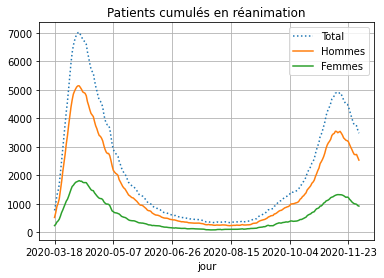

In [46]:
#cov_a = cov.loc[cov['sexe'] == 0]
rea_hf = cov_0.groupby("jour").rea.sum()

#cov_h = cov.loc[cov['sexe'] == 1]
rea_h = cov_1.groupby("jour").rea.sum()

#cov_f = cov.loc[cov['sexe'] == 2]
rea_f = cov_2.groupby("jour").rea.sum()

rea_hf.plot(linestyle=':')
rea_h.plot()
graph = rea_f.plot(title="Patients cumulés en réanimation", grid=True, legend=True)
graph.legend(["Total", "Hommes", "Femmes"])

### Décès
Nombre de décès mis à jour quotidiennement pour les décès survenant à l’hôpital, les décès survenant au sein des établissements sociaux et médico-sociaux ne sont ici pas comptabilisés

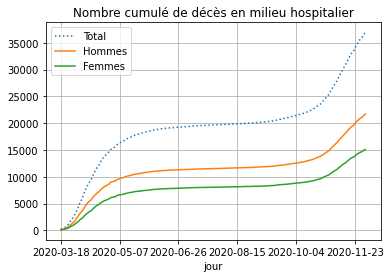

In [47]:
dc_0 = cov_0.groupby("jour").dc.sum()
dc_1 = cov_1.groupby("jour").dc.sum()
dc_2 = cov_2.groupby("jour").dc.sum()

dc_0.plot(linestyle=':')
dc_1.plot()
graph = dc_2.plot(title="Nombre cumulé de décès en milieu hospitalier", grid=True)
graph.legend(["Total", "Hommes", "Femmes"])

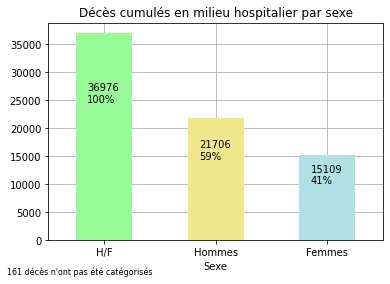

In [50]:
last_dcHF = dc_0[len(dc_0)-1]
last_dcH = dc_1[len(dc_1)-1]
last_dcF = dc_2[len(dc_2)-1]
no_class = last_dcHF - (last_dcH + last_dcF)

df = pd.DataFrame({'Sexe':['H/F', 'Hommes', 'Femmes'], 'Décès':[last_dcHF, last_dcH, last_dcF]})
color = ["palegreen", "khaki", "powderblue"]
ax = df.plot.bar(x='Sexe', y='Décès', rot=0, color=color, legend=False, title = f"Décès cumulés en milieu hospitalier par sexe", grid=True)
ax.set_axisbelow(True)

foot_txt = f"{no_class} décès n'ont pas été catégorisés"
plt.figtext(0.03, 0.004, foot_txt, fontsize=8)

x_offset = -0.15
for p in ax.patches:
    b = p.get_bbox()
    val = "{:.0f}\n{}%".format(b.y1, round((b.y1/last_dcHF)*100))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 - (b.y1/3)))